# Assignment 2
Check the official page of the challenge [here](https://touche.webis.de/semeval23/touche23-web/).

Check the paper [here](https://aclanthology.org/2022.acl-long.306.pdf).

## Preliminaries
Package installs and imports

In [ ]:
!pip install transformers[torch]
!pip install datasets==2.13.2
!pip install evaluate
!pip install tabulate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.7/512.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.1 MB/s eta 0:00:00


In [ ]:
import evaluate
import os
import torch
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from tabulate import tabulate
from torch import nn
from transformers import AutoTokenizer, BertModel, BertPreTrainedModel, Trainer, TrainingArguments
from transformers.modeling_outputs import SequenceClassifierOutput
from typing import Optional, Tuple, Union
from urllib.request import urlretrieve

from transformers import AutoModelForSequenceClassification as SeqClass
from transformers import DataCollatorWithPadding as Collator

from scipy.stats import mode

## [Task 1] Corpus

The standard splits (also used here) contain

   * **Train**: 5393 arguments
   * **Validation**: 1896 arguments
   * **Test**: 1576 arguments

### Step 1 - Download & extract dataset

In [ ]:
# Prepare dataset location
root_dir = "/content"
dataset_root = os.path.join(root_dir, "dataset")
dataset_zip_path = os.path.join(root_dir, "dataset.zip")

# Download dataset
dataset_url = "https://drive.google.com/uc?export=download&id=1cLcOB5ZzOhaDGzZ8gIecEuw-oTuZC8oV"
urlretrieve(dataset_url, dataset_zip_path)

# Extract data from zip file
with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
  zip_ref.extractall(root_dir)

### Step 2 - Create DataFrame

In [ ]:
# Prepare dataset paths
arguments_path = os.path.join(dataset_root, "arguments")
labels_path = os.path.join(dataset_root, "human_values")

In [ ]:
# Get arguments
train_x_df = pd.read_csv(
    os.path.join(arguments_path, "arguments-training.tsv"),
    sep="\t"
)

val_x_df = pd.read_csv(
    os.path.join(arguments_path, "arguments-validation.tsv"),
    sep="\t"
)

test_x_df = pd.read_csv(
    os.path.join(arguments_path, "arguments-test.tsv"),
    sep="\t"
)

# Show example
test_x_df.head()

,Argument ID,Conclusion,Stance,Premise
0,A26004,We should end affirmative action,against,affirmative action helps with employment equity.
1,A26010,We should end affirmative action,in favor of,affirmative action can be considered discrimin...
2,A26016,We should ban naturopathy,in favor of,naturopathy is very dangerous for the most vul...
3,A26024,We should prohibit women in combat,in favor of,women shouldn't be in combat because they aren...
4,A26026,We should ban naturopathy,in favor of,once eradicated illnesses are returning due to...


In [ ]:
# Get human values
train_y_df = pd.read_csv(
    os.path.join(labels_path, "labels-training.tsv"),
    sep="\t"
)

val_y_df = pd.read_csv(
    os.path.join(labels_path, "labels-validation.tsv"),
    sep="\t"
)

test_y_df = pd.read_csv(
    os.path.join(labels_path, "labels-test.tsv"),
    sep="\t"
)

# Show example
test_y_df.head()

,Argument ID,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A26004,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1,A26010,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
2,A26016,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
3,A26024,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A26026,0,0,0,0,1,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0


### Step 3 - Merge annotations
Decided to do it before merging the training and label dataframes, so that we work on slightly smaller DataFrames.

In [ ]:
# Define mapping
l3_to_l2_map = {
    "Openness to change": [
        "Self-direction: thought",
        "Self-direction: action",
        "Stimulation",
        "Hedonism"
    ],
    "Self-enhancement": [
        "Hedonism",
        "Achievement",
        "Power: dominance",
        "Power: resources",
        "Face"
    ],
    "Conservation": [
        "Face",
        "Security: personal",
        "Security: societal",
        "Tradition",
        "Conformity: rules",
        "Conformity: interpersonal",
        "Humility"
    ],
    "Self-transcendence": [
        "Humility",
        "Benevolence: caring",
        "Benevolence: dependability",
        "Universalism: concern",
        "Universalism: nature",
        "Universalism: tolerance",
        "Universalism: objectivity"
    ]
}

l3_classes = list(l3_to_l2_map.keys())

In [ ]:
# Create merge function, since we will apply the same method to 3 dfs
def or_columns(df, mapping):
  """
  The mapping argument needs to have the following structure:
    - keys: the names of the new columns to be added
    - values: lists with the names of the old columns on which the or operation
              will be applied
  """

  # Iterate through the l3 classes
  for key in mapping.keys():
    # Prepare a new empty column
    new_col = np.zeros([len(df)], dtype=bool)

    # Iterate through l2 columns that map to current l3 class
    for el in mapping[key]:
      # Get l2 column
      cur_col = np.array(df[el], dtype=bool)

      # Apply logical or with result obtained so far in new column
      new_col = np.logical_or(new_col, cur_col)

    # Add new column to DataFrame
    df[key] = new_col.astype('uint8')

  return df

In [ ]:
# Apply merge function
or_columns(train_y_df, l3_to_l2_map)
or_columns(val_y_df, l3_to_l2_map)
or_columns(test_y_df, l3_to_l2_map)

val_y_df.head()

,Argument ID,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,...,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity,Openness to change,Self-enhancement,Conservation,Self-transcendence
0,A01001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,A01012,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,A02001,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,1
3,A02002,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,A02009,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,1


### Step 4 - Add numeric column
Adding a numerical version of the Stance column that will be named Numerical Stance

In [ ]:
train_x_df["Numerical Stance"] = (train_x_df["Stance"] == "in favor of").astype(int)
val_x_df["Numerical Stance"] = (val_x_df["Stance"] == "in favor of").astype(int)
test_x_df["Numerical Stance"] = (test_x_df["Stance"] == "in favor of").astype(int)

val_x_df.head()

,Argument ID,Conclusion,Stance,Premise,Numerical Stance
0,A01001,Entrapment should be legalized,in favor of,if entrapment can serve to more easily capture...,1
1,A01012,The use of public defenders should be mandatory,in favor of,the use of public defenders should be mandator...,1
2,A02001,Payday loans should be banned,in favor of,payday loans create a more impoverished societ...,1
3,A02002,Surrogacy should be banned,against,Surrogacy should not be banned as it is the wo...,0
4,A02009,Entrapment should be legalized,against,entrapment is gravely immoral and against huma...,0


Also adding numerical value to y, to have an array of 0/1 values for each class (in the format required for the training, including them being of type float).

In [ ]:
train_y_df["label"] = train_y_df[l3_classes].values.astype(float).tolist()
val_y_df["label"] = val_y_df[l3_classes].values.astype(float).tolist()
test_y_df["label"] = test_y_df[l3_classes].values.astype(float).tolist()

### Step 5 - Merge dataframes

In [ ]:
train_df = pd.merge(train_x_df, train_y_df, on="Argument ID")
val_df = pd.merge(val_x_df, val_y_df, on="Argument ID")
test_df = pd.merge(test_x_df, test_y_df, on="Argument ID")

test_df.head()

,Argument ID,Conclusion,Stance,Premise,Numerical Stance,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,...,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity,Openness to change,Self-enhancement,Conservation,Self-transcendence,label
0,A26004,We should end affirmative action,against,affirmative action helps with employment equity.,0,0,0,0,0,1,...,0,1,0,1,0,0,1,1,1,"[0.0, 1.0, 1.0, 1.0]"
1,A26010,We should end affirmative action,in favor of,affirmative action can be considered discrimin...,1,0,0,0,0,1,...,0,1,0,1,1,0,1,0,1,"[0.0, 1.0, 0.0, 1.0]"
2,A26016,We should ban naturopathy,in favor of,naturopathy is very dangerous for the most vul...,1,0,0,0,0,1,...,1,1,0,0,0,0,1,1,1,"[0.0, 1.0, 1.0, 1.0]"
3,A26024,We should prohibit women in combat,in favor of,women shouldn't be in combat because they aren...,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,"[0.0, 1.0, 0.0, 0.0]"
4,A26026,We should ban naturopathy,in favor of,once eradicated illnesses are returning due to...,1,0,0,0,0,1,...,1,0,0,0,0,0,1,1,1,"[0.0, 1.0, 1.0, 1.0]"


### Step 6 - Create dataset objects

In [ ]:
X_train = train_df[["Conclusion", "Premise", "Numerical Stance"]]
X_val = val_df[["Conclusion", "Premise", "Numerical Stance"]]
X_test = test_df[["Conclusion", "Premise", "Numerical Stance"]]

y_train = train_df["label"]
y_val = val_df["label"]
y_test = test_df["label"]

In [ ]:
train_data = Dataset.from_pandas(pd.concat([X_train, y_train], axis=1))
val_data = Dataset.from_pandas(pd.concat([X_val, y_val], axis=1))
test_data = Dataset.from_pandas(pd.concat([X_test, y_test], axis=1))

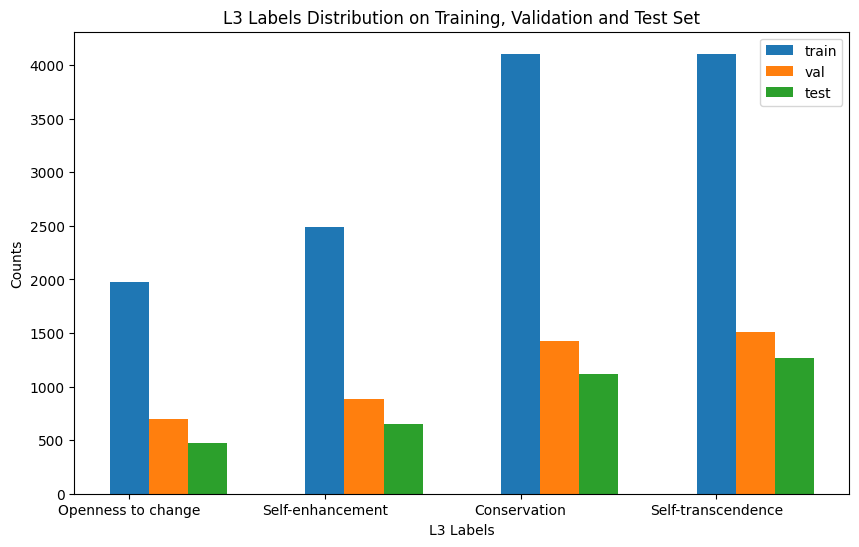

In [ ]:
l3_distribution_train = train_y_df[l3_classes].sum()
l3_distribution_val = val_y_df[l3_classes].sum()
l3_distribution_test = test_y_df[l3_classes].sum()

plt.figure(figsize=(10,6))

X_axis = np.arange(4)

# Plot the bar chart
plt.bar(X_axis, l3_distribution_train, 0.2, label='train')
plt.bar(X_axis + 0.2,l3_distribution_val, 0.2, label='val')
plt.bar(X_axis + 0.4,l3_distribution_test, 0.2, label='test')

plt.xticks(X_axis, l3_classes)
plt.xlabel("L3 Labels")
plt.ylabel("Counts")
plt.title("L3 Labels Distribution on Training, Validation and Test Set")
plt.legend()
plt.show()

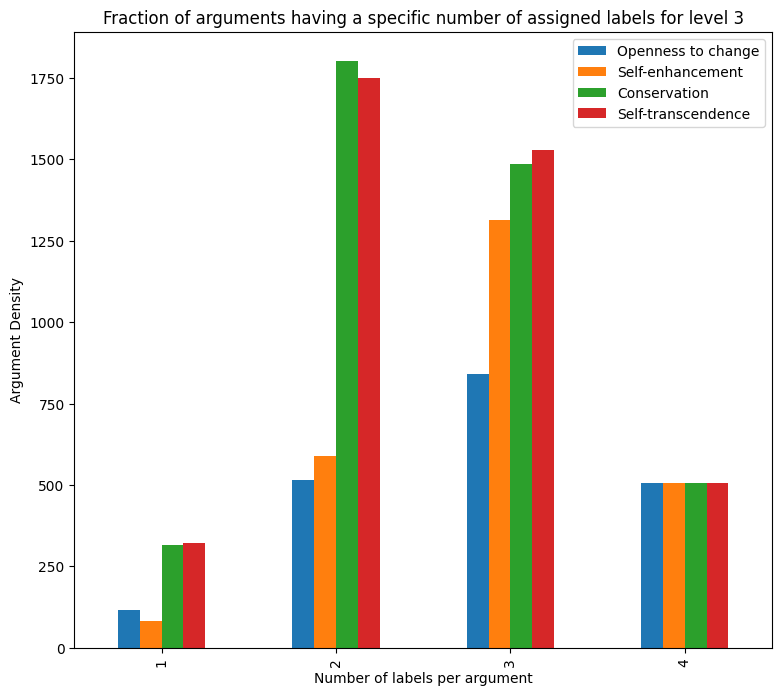

In [ ]:
label1 = train_df[train_df[l3_classes].sum(axis=1)==1][l3_classes].sum(axis=0).values
label2 = train_df[train_df[l3_classes].sum(axis=1)==2][l3_classes].sum(axis=0).values
label3 = train_df[train_df[l3_classes].sum(axis=1)==3][l3_classes].sum(axis=0).values
label4 = train_df[train_df[l3_classes].sum(axis=1)==4][l3_classes].sum(axis=0).values

data=[["1"] + list(label1),
      ["2"] + list(label2),
      ["3"] + list(label3),
      ["4"] + list(label4)
     ]

# Plot multiple columns bar chart
df=pd.DataFrame(data,columns=["Name"]+l3_classes)
df.plot(x="Name", y=l3_classes, kind="bar",figsize=(9,8))

# Show
plt.xlabel("Number of labels per argument")
plt.ylabel("Argument Density")
plt.title("Fraction of arguments having a specific number of assigned labels for level 3")

plt.show()

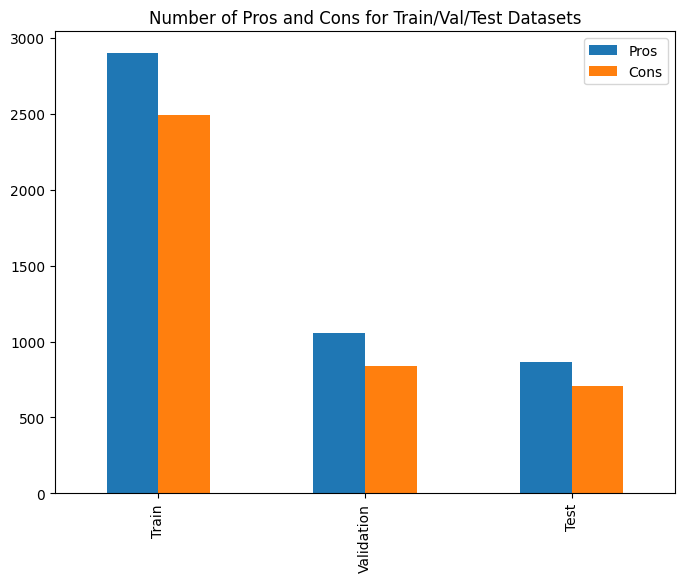

In [ ]:
train_pros = train_df['Numerical Stance'].sum()
train_cons = len(train_df) - train_pros

val_pros = val_df['Numerical Stance'].sum()
val_cons = len(val_df) - val_pros

test_pros = test_df['Numerical Stance'].sum()
test_cons = len(test_df) - test_pros

x = [0,1,2]
labels = ['Train','Validation','Test']

data=[[train_pros,train_cons],
      [val_pros,val_cons],
      [test_pros, test_cons]
     ]

# Plot multiple columns bar chart
df=pd.DataFrame(data, columns = ['Pros','Cons'])
df.plot( kind="bar",figsize=(8,6))

# Show
plt.title("Number of Pros and Cons for Train/Val/Test Datasets")
plt.xticks(x,labels)
plt.show()

## [Task 2] Model definition

### Baselines

#### Baseline 1
Random uniform classifier (individual classifier per category)

In [ ]:
baseline_1 = DummyClassifier(strategy="uniform")

#### Baseline 2
Majority classifier (individual classifier per category)

In [ ]:
baseline_2 = DummyClassifier(strategy="most_frequent")

### BERT Models
We decided to use bert-base-uncased because it's slightly smaller than roberta-base (albeit, with poorer performance on benchmarks), and it's also case-sensitive, which, given our dataset, would not be useful.

In [ ]:
model_card = 'bert-base-uncased'

#### Preliminaries

##### Tokenization

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_card)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def preprocess_conclusion(texts):
  return tokenizer(texts["Conclusion"])

def preprocess_cp(texts):
  return tokenizer(texts["Conclusion"], texts["Premise"])

In [ ]:
# Tokenize Conclusion column
train_c = train_data.map(preprocess_conclusion, batched=True)
val_c = val_data.map(preprocess_conclusion, batched=True)
test_c = test_data.map(preprocess_conclusion, batched=True)

# Tokenize Conclusion and Premise columns together
train_cp = train_data.map(preprocess_cp, batched=True)
val_cp = val_data.map(preprocess_cp, batched=True)
test_cp = test_data.map(preprocess_cp, batched=True)

In [ ]:
# Print demo sentences
def demo_sentence_print(data, tokenizer, columns):
  print(data)
  print()
  print("Original sentences")
  for column in columns:
    print(data[column][50])

  print("\nTokenization result")
  print(data['input_ids'][50])
  print(data['attention_mask'][50])

  print("\nDecoded sentence")
  print(tokenizer.decode(data['input_ids'][50]))

demo_sentence_print(test_c, tokenizer, ["Conclusion"])
print("\n\n")
demo_sentence_print(test_cp, tokenizer, ["Premise"])

Dataset({
    features: ['Conclusion', 'Premise', 'Numerical Stance', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1576
})

Original sentences
We should close Guantanamo Bay detention camp

Tokenization result
[101, 2057, 2323, 2485, 23094, 3016, 12345, 3409, 102]
[1, 1, 1, 1, 1, 1, 1, 1, 1]

Decoded sentence
[CLS] we should close guantanamo bay detention camp [SEP]



Dataset({
    features: ['Conclusion', 'Premise', 'Numerical Stance', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1576
})

Original sentences
we need to keep guantanamo bay detention camp open as we need a place to keep the worst of the worst criminals and not place them in other countries where they could cause harm to others.

Tokenization result
[101, 2057, 2323, 2485, 23094, 3016, 12345, 3409, 102, 2057, 2342, 2000, 2562, 23094, 3016, 12345, 3409, 2330, 2004, 2057, 2342, 1037, 2173, 2000, 2562, 1996, 5409, 1997, 1996, 5

In [ ]:
train_token_length = pd.DataFrame([[i.index(102)-1, len(i)-i.index(102)-2] for i in train_cp['input_ids']], columns = ['conclusion_token_length', 'premise_token_length'])
val_token_length = pd.DataFrame([[i.index(102)-1, len(i)-i.index(102)-2] for i in val_cp['input_ids']], columns = ['conclusion_token_length', 'premise_token_length'])
test_token_length = pd.DataFrame([[i.index(102)-1, len(i)-i.index(102)-2] for i in test_cp['input_ids']], columns = ['conclusion_token_length', 'premise_token_length'])

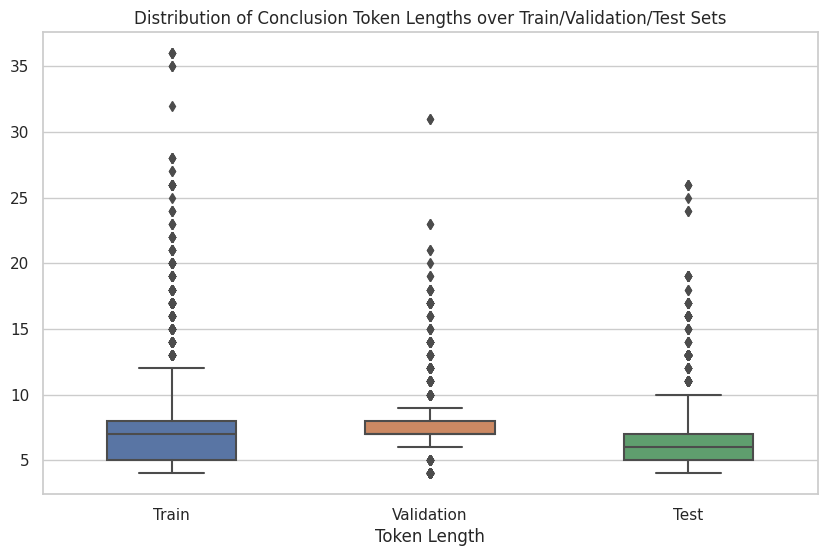

In [ ]:
plt.figure(figsize=(10, 6))

sns.set_theme(style="whitegrid")

x = [0,1,2]
labels = ['Train','Validation','Test']

sns.boxplot(
    data=[
        train_token_length['conclusion_token_length'],
        val_token_length['conclusion_token_length'],
        test_token_length['conclusion_token_length']],
    width=0.5,
    fliersize=5)

plt.title('Distribution of Conclusion Token Lengths over Train/Validation/Test Sets')
plt.xlabel('Token Length')
plt.xticks(x,labels)
plt.show()

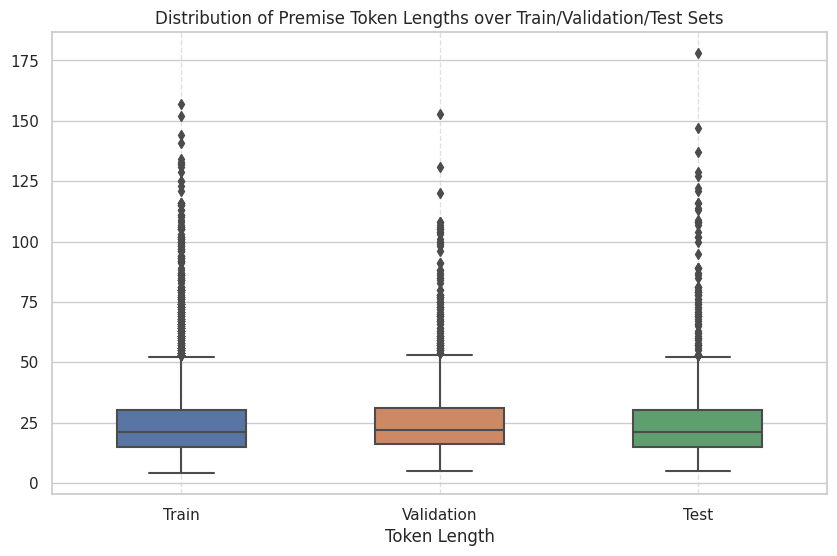

In [ ]:
plt.figure(figsize=(10, 6))

sns.set_theme(style="whitegrid")

x = [0,1,2]
labels = ['Train','Validation','Test']

sns.boxplot(
    data=[
        train_token_length['premise_token_length'],
        val_token_length['premise_token_length'],
        test_token_length['premise_token_length']],
    width=0.5,
    fliersize=5)

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.title('Distribution of Premise Token Lengths over Train/Validation/Test Sets')
plt.xlabel('Token Length')
plt.xticks(x,labels)

plt.show()

##### Data Formatting

In [ ]:
data_collator = Collator(tokenizer=tokenizer)

#### Model Definition

##### BERT with C
BERT-based classifier with conclusion as input

In [ ]:
class CustomBertMLC_c(BertPreTrainedModel):
  def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        self.bert = BertModel(config)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.sigmoid = nn.Sigmoid()

        # Initialize weights and apply final processing
        self.post_init()

  def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        cat_feats: Optional[torch.Tensor] = None,
    ) -> Union[Tuple[torch.Tensor], SequenceClassifierOutput]:
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = self.dropout(outputs[1])

        # Concatanation before classification
        logits = self.classifier(pooled_output)
        logits = self.sigmoid(logits)

        loss = None
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss()
            loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
bert_c = CustomBertMLC_c.from_pretrained(
    model_card,
    num_labels=len(l3_classes),
    problem_type="multi_label_classification"
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of CustomBertMLC_c were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(bert_c)

CustomBertMLC_c(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

##### BERT with CP
Same as previous, with premise as additional input. Custom multi label classification model, based on BertForSequenceClassification from [here](https://github.com/huggingface/transformers/blob/v4.35.2/src/transformers/models/bert/modeling_bert.py#L1519), and a [public repository](https://github.com/georgian-io/Multimodal-Toolkit/blob/master/multimodal_transformers/model/tabular_transformers.py#L29) trying to solve a similar issue. The other steps are similar to the other BERT model.

In [ ]:
class CustomBertMLC_cp(BertPreTrainedModel):
  def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        self.bert = BertModel(config)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(config.hidden_size * 2, config.num_labels)
        self.sigmoid = nn.Sigmoid()

        # Initialize weights and apply final processing
        self.post_init()

  def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        cat_feats: Optional[torch.Tensor] = None,
    ) -> Union[Tuple[torch.Tensor], SequenceClassifierOutput]:
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # Separate conclusion and premise
        # Create separate input_ids
        input_ids_c = input_ids.clone()
        input_ids_p = input_ids.clone()

        # Select elements starting from first occurence of [SEP] (102)
        idx = torch.cumsum(input_ids_c == 102, axis=1) > 0

        # Set premise to 0
        input_ids_c[idx] = 0

        # Set conclusion to 0
        input_ids_p[~idx] = 0

        # Reintroduce [SEP], which works as sentence finishing token
        input_ids_c[
            range(len(input_ids_c)),
            np.argmax(input_ids_c.cpu() == 0, axis=1)] = 102

        # Replace [SEP] in begining of premise with [CLS] (101)
        input_ids_p[
            range(len(input_ids_p)),
            np.argmax(input_ids_p.cpu() == 102, axis=1)] = 101

        # Same procedure for attention mask, using input_ids
        attention_mask_c = attention_mask.clone()
        attention_mask_p = attention_mask.clone()

        attention_mask_c[input_ids_c == 0] = 0
        attention_mask_p[input_ids_p == 0] = 0

        # token_type_ids must all be set to 0 (set to 1 by tokenizer when first
        # [SEP] is met, but after separation, no more 2 sentences)
        token_type_ids[token_type_ids != 0] = 0

        # 2 separate pipelines from now on, for conclusion and premise
        # Conclusion
        outputs_c = self.bert(
            input_ids_c,
            attention_mask=attention_mask_c,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output_c = outputs_c[1]
        pooled_output_c = self.dropout(pooled_output_c)

        # Premise
        outputs_p = self.bert(
            input_ids_p,
            attention_mask=attention_mask_p,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output_p = outputs_p[1]
        pooled_output_p = self.dropout(pooled_output_p)

        # Concatanation before classification
        logits = self.classifier(torch.cat(
            [pooled_output_c, pooled_output_p],
            dim=1))
        logits = self.sigmoid(logits)

        loss = None
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss()
            loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs_p.hidden_states,
            attentions=outputs_p.attentions,
        )

In [ ]:
bert_cp = CustomBertMLC_cp.from_pretrained(
    model_card,
    num_labels=len(l3_classes),
    problem_type="multi_label_classification"
)

Some weights of CustomBertMLC_cp were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(bert_cp)

CustomBertMLC_cp(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

##### BERT with CPS
Same as previous, with stance as additional input

In [ ]:
train_cps = train_cp.rename_column("Numerical Stance", "numerical_stance")
val_cps = val_cp.rename_column("Numerical Stance", "numerical_stance")
test_cps = test_cp.rename_column("Numerical Stance", "numerical_stance")

In [ ]:
class CustomBertMLC_cps(BertPreTrainedModel):
  def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        self.bert = BertModel(config)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(config.hidden_size * 2 + 1, config.num_labels)
        self.sigmoid = nn.Sigmoid()

        # Initialize weights and apply final processing
        self.post_init()

  def forward(
        self,
        numerical_stance: Optional[torch.Tensor] = None,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        cat_feats: Optional[torch.Tensor] = None,
    ) -> Union[Tuple[torch.Tensor], SequenceClassifierOutput]:
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # Separate conclusion and premise
        # Create separate input_ids
        input_ids_c = input_ids.clone()
        input_ids_p = input_ids.clone()

        # Select elements starting from first occurence of [SEP] (102)
        idx = torch.cumsum(input_ids_c == 102, axis=1) > 0

        # Set premise to 0
        input_ids_c[idx] = 0

        # Set conclusion to 0
        input_ids_p[~idx] = 0

        # Reintroduce [SEP], which works as sentence finishing token
        input_ids_c[
            range(len(input_ids_c)),
            np.argmax(input_ids_c.cpu() == 0, axis=1)] = 102

        # Replace [SEP] in begining of premise with [CLS] (101)
        input_ids_p[
            range(len(input_ids_p)),
            np.argmax(input_ids_p.cpu() == 102, axis=1)] = 101

        # Same procedure for attention mask, using input_ids
        attention_mask_c = attention_mask.clone()
        attention_mask_p = attention_mask.clone()

        attention_mask_c[input_ids_c == 0] = 0
        attention_mask_p[input_ids_p == 0] = 0

        # token_type_ids must all be set to 0 (set to 1 by tokenizer when first
        # [SEP] is met, but after separation, no more 2 sentences)
        token_type_ids[token_type_ids != 0] = 0

        # 2 separate pipelines from now on, for conclusion and premise
        # Conclusion
        outputs_c = self.bert(
            input_ids_c,
            attention_mask=attention_mask_c,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output_c = outputs_c[1]
        pooled_output_c = self.dropout(pooled_output_c)

        # Premise
        outputs_p = self.bert(
            input_ids_p,
            attention_mask=attention_mask_p,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output_p = outputs_p[1]
        pooled_output_p = self.dropout(pooled_output_p)

        # Add dimension to numerical_stance
        numerical_stance = torch.reshape(
            numerical_stance,
             (numerical_stance.size()[0], 1))

        # Concatanation before classification
        logits = self.classifier(torch.cat(
            [pooled_output_c, pooled_output_p, numerical_stance],
            dim=1))
        logits = self.sigmoid(logits)

        loss = None
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss()
            loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs_p.hidden_states,
            attentions=outputs_p.attentions,
        )

In [ ]:
bert_cps = CustomBertMLC_cps.from_pretrained(
    model_card,
    num_labels=len(l3_classes),
    problem_type="multi_label_classification"
)

Some weights of CustomBertMLC_cps were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(bert_cps)

CustomBertMLC_cps(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

## [Task 3] Metrics

In [ ]:
def transform_data(predictions,labels,thresholds):

  for i in range(4):

    predictions[:,i][predictions[:,i] < thresholds[i]] = 0
    predictions[:,i][predictions[:,i] >= thresholds[i]] = 1

  return predictions,labels

In [ ]:
acc_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')

def compute_metrics(predictions,labels):

    f1_list = []
    acc_list = []

    for i in range(4):

      f1 = f1_metric.compute(predictions=predictions[:,i], references=labels[:,i], average='macro')
      acc = acc_metric.compute(predictions=predictions[:,i], references=labels[:,i])
      f1_list.append(list(f1.values())[0])
      acc_list.append(list(acc.values())[0])
    return f1_list,acc_list


In [ ]:
def compute_avg_f1(f1_list):
  return sum(f1_list) / len(f1_list)

In [ ]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

## [Task 4] Training and Evaluation

### Baselines
The training process of these ones consists only in passing the labels, such that the model will set the output when called, based on the initial given strategy. The X part of the data is actually ignored.

#### Baseline 1
Random uniform classifier

In [ ]:
# "Fit" to activate random uniform classification on predict call
baseline_1.fit(
    X=None,
    y=y_train,
);

In [ ]:
# Demo output
base1_pred = baseline_1.predict(X_test)

In [ ]:
f1_base1_list , acc_base1_list = compute_metrics(np.array([np.array(i) for i in base1_pred]), np.array([np.array(i) for i in y_test]))

In [ ]:
f1_base1_list

[0.4675173034020501,
 0.5029632620366812,
 0.47039831362111173,
 0.4525669256168217]

In [ ]:
acc_base1_list

[0.48223350253807107,
 0.5063451776649747,
 0.4885786802030457,
 0.5006345177664975]

#### Baseline 2
Majority classifier

In [ ]:
# "Fit" to activate majority classification on predict call
baseline_2.fit(
    X=None,
    y=y_train,
);

In [ ]:
# Demo output
base2_pred = baseline_2.predict(X_test)

In [ ]:
from sklearn.metrics import precision_score

for i in range(4):
  print(precision_score(np.array([np.array(i) for i in y_test])[:,i], base2_pred.reshape(1576,4)[:,i]))

0.0
0.0
0.7100253807106599
0.8045685279187818


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
f1_base2_list , acc_base2_list = compute_metrics(base2_pred.reshape(1576,4), np.array([np.array(i) for i in y_test]))

In [ ]:
f1_base2_list

[0.4115011202389843,
 0.37085828343313376,
 0.41521335807050097,
 0.4458509142053446]

In [ ]:
acc_base2_list

[0.699238578680203, 0.5894670050761421, 0.7100253807106599, 0.8045685279187818]

### BERT Models

#### BERT with C

In [ ]:
c_training_args = TrainingArguments(
    output_dir="c_test_dir",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit = 2,
    load_best_model_at_end=True,
    report_to='none',
    lr_scheduler_type="cosine_with_restarts",
    weight_decay=0.01
)

Epoch,Training Loss,Validation Loss
1,0.614000,0.621603
2,0.611900,0.616446
3,0.608200,0.617600
4,0.606100,0.616379
5,0.603900,0.620279
6,0.604000,0.625749
7,0.603700,0.618684
8,0.599900,0.618919
9,0.600500,0.620519
10,0.601600,0.621084



AUC-ROC score for Openness to change is: 0.5565867965417691
Threshold value for Openness to change is: 0.0020536


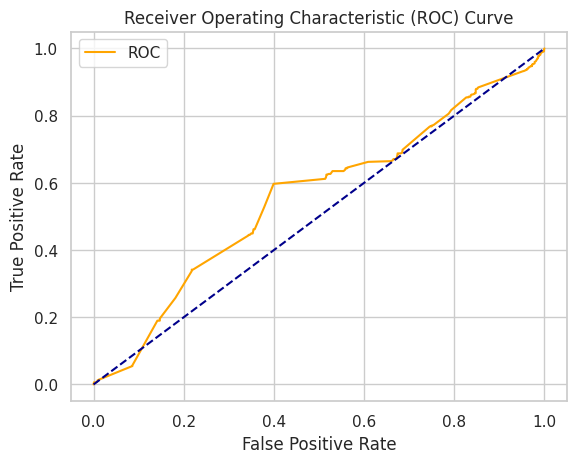


AUC-ROC score for Self-enhancement is: 0.6122028805632687
Threshold value for Self-enhancement is: 0.0007056735


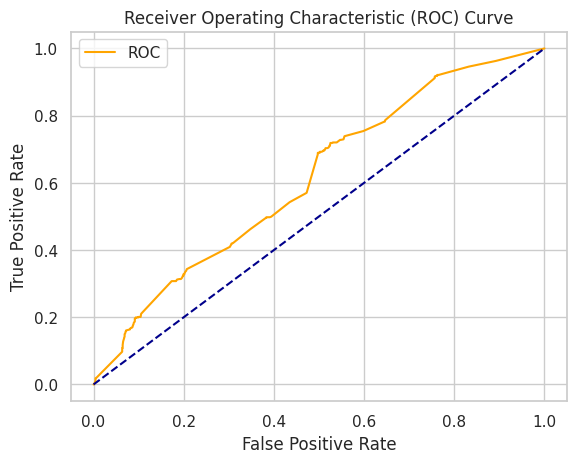


AUC-ROC score for Conservation is: 0.5426402520224567
Threshold value for Conservation is: 0.9973955


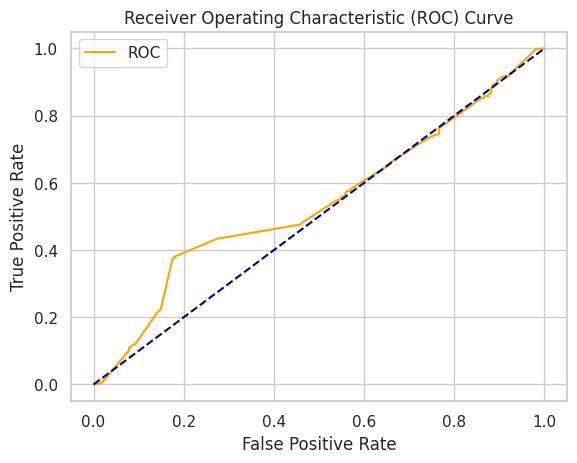


AUC-ROC score for Self-transcendence is: 0.6514528452619935
Threshold value for Self-transcendence is: 0.9799044


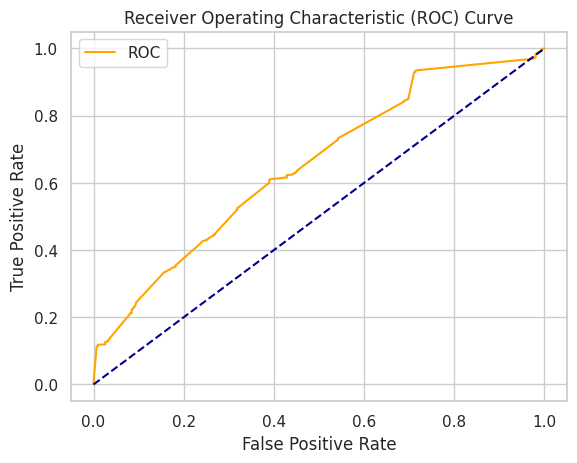

Seed 42: Test accuracy = [0.5996192893401016, 0.5748730964467005, 0.508248730964467, 0.807741116751269], Test f1 score = [0.5750433201503332, 0.5747744845360825, 0.5076919604331698, 0.6270381851453528]


Epoch,Training Loss,Validation Loss
1,0.604800,0.618090
2,0.603500,0.614896
3,0.602400,0.614807
4,0.599700,0.611491
5,0.600300,0.616779
6,0.599700,0.629543
7,0.600200,0.621414
8,0.597400,0.619892
9,0.599100,0.627581
10,0.599900,0.637335



AUC-ROC score for Openness to change is: 0.5981041374715707
Threshold value for Openness to change is: 0.0006655523


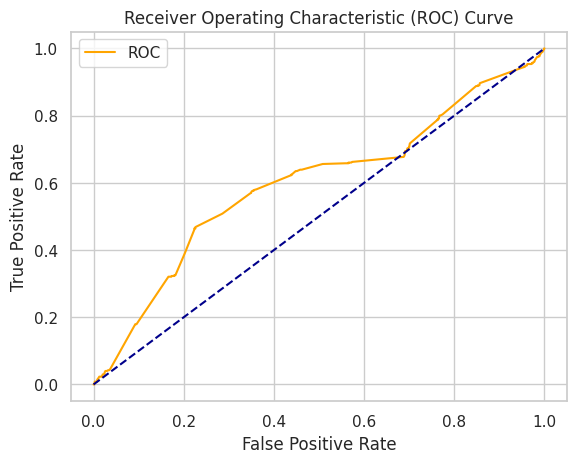


AUC-ROC score for Self-enhancement is: 0.6183811014818746
Threshold value for Self-enhancement is: 0.0005105335


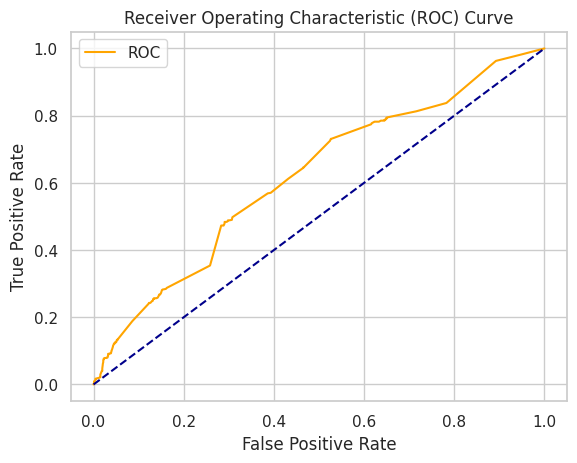


AUC-ROC score for Conservation is: 0.5171857492329623
Threshold value for Conservation is: 0.99373335


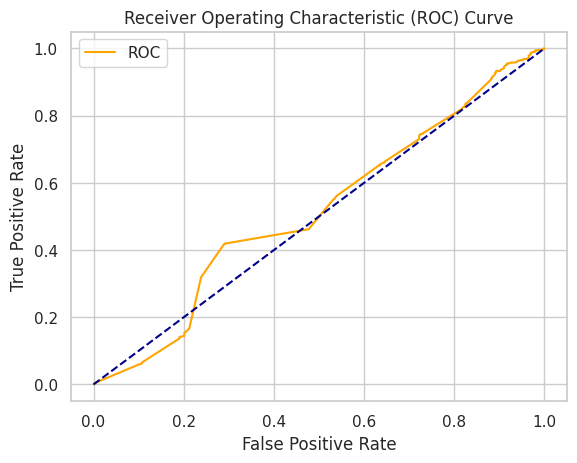


AUC-ROC score for Self-transcendence is: 0.6296294399606701
Threshold value for Self-transcendence is: 0.9966449


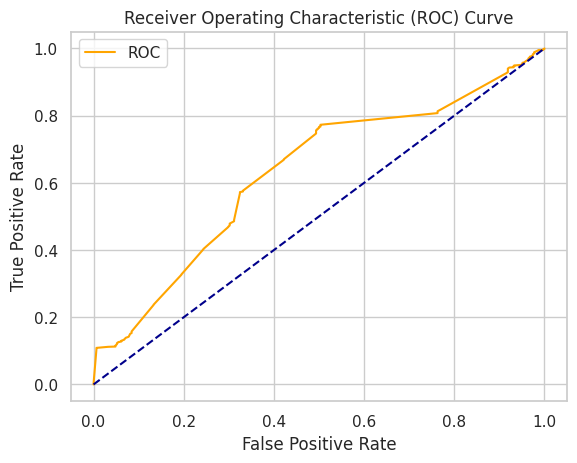

Seed 123: Test accuracy = [0.6821065989847716, 0.5793147208121827, 0.5031725888324873, 0.7189086294416244], Test f1 score = [0.6214181428499507, 0.5791301924084671, 0.49893107342155174, 0.6120959170418374]


Epoch,Training Loss,Validation Loss
1,0.598800,0.625081
2,0.598300,0.617715
3,0.602000,0.624266
4,0.599200,0.617117
5,0.598800,0.622216
6,0.598900,0.625833
7,0.600800,0.629982
8,0.597200,0.625124
9,0.598800,0.629294
10,0.599300,0.631365



AUC-ROC score for Openness to change is: 0.5846839654789527
Threshold value for Openness to change is: 0.00037043725


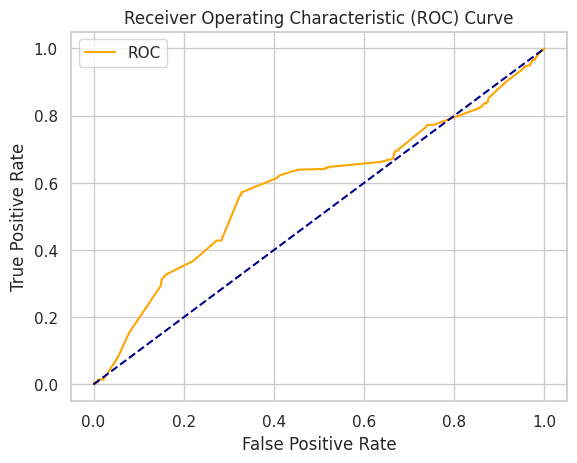


AUC-ROC score for Self-enhancement is: 0.6141169894004457
Threshold value for Self-enhancement is: 0.00046204764


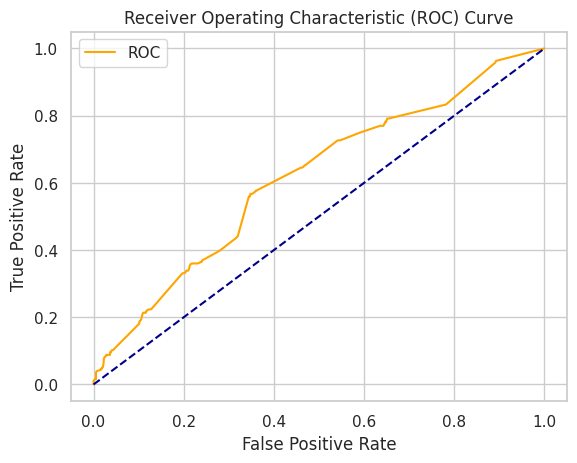


AUC-ROC score for Conservation is: 0.5913200086823379
Threshold value for Conservation is: 0.9983


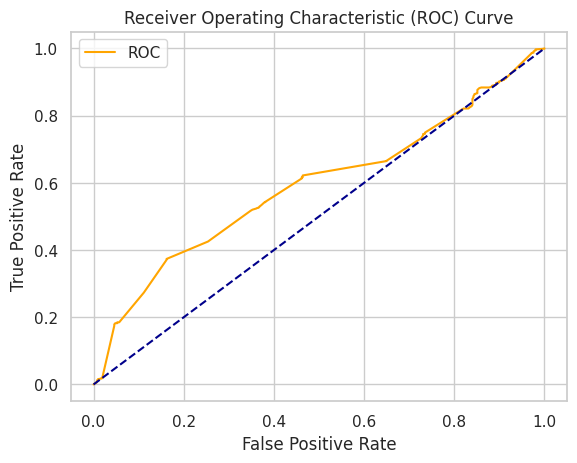


AUC-ROC score for Self-transcendence is: 0.6539826498422713
Threshold value for Self-transcendence is: 0.9983235


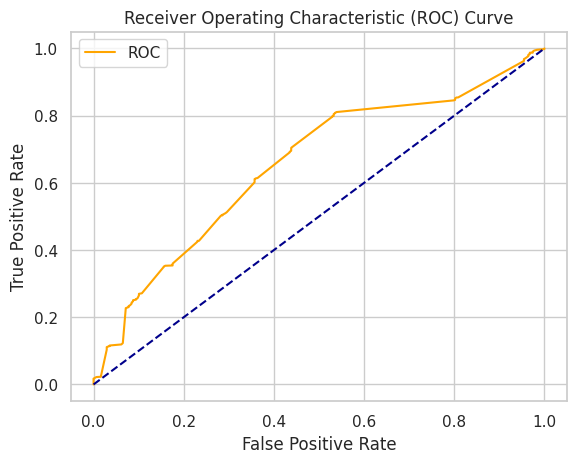

Seed 999: Test accuracy = [0.6421319796954315, 0.6173857868020305, 0.508248730964467, 0.7411167512690355], Test f1 score = [0.6071972127504999, 0.6083794358901451, 0.5080060792305979, 0.6230575688863981]


In [ ]:
seeds = [42, 123, 999]
num_epochs = 20
models_1 = {}

for seed in seeds:
    np.random.seed(seed)
    torch.manual_seed(seed)

    trainer_c = Trainer(
        model=bert_c,
        args=c_training_args,
        train_dataset=train_c,
        eval_dataset=val_c,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )

    trainer_c.train()

    models_1[seed] = trainer_c

    test_prediction_c_info = trainer_c.predict(test_c)
    test_predictions_c = test_prediction_c_info.predictions
    test_labels_c = test_prediction_c_info.label_ids

    thresholds_list_c = []
    for i in range(4):
      y_true = test_labels_c[:,i]
      y_scores = test_predictions_c[:,i]

      fpr, tpr, thresholds = roc_curve(y_true, y_scores)
      print()
      print(f"AUC-ROC score for {l3_classes[i]} is:", roc_auc_score(y_true, y_scores))

      optimal_idx = np.argmax(tpr - fpr)
      optimal_threshold = thresholds[optimal_idx]
      print(f"Threshold value for {l3_classes[i]} is:", optimal_threshold)

      thresholds_list_c.append(optimal_threshold)
      plot_roc_curve(fpr, tpr)

    pred_c, label_c = transform_data(test_predictions_c, test_labels_c, thresholds_list_c)
    f1_list_c, acc_list_c = compute_metrics(pred_c, label_c)
    print(f"Seed {seed}: Test accuracy = {acc_list_c}, Test f1 score = {f1_list_c}")

In [ ]:
acc_list_c

[0.6421319796954315, 0.6173857868020305, 0.508248730964467, 0.7411167512690355]

In [ ]:
f1_list_c,

([0.6071972127504999,
  0.6083794358901451,
  0.5080060792305979,
  0.6230575688863981],)

<b>We create the folder to save the best models </b>

In [ ]:
checkpoints_folder = 'best_checkpoints'
checkpoints_path = os.path.join(os.getcwd(), checkpoints_folder)

if not os.path.exists(checkpoints_path):
    os.mkdir(checkpoints_path)

c_path = os.path.join(checkpoints_path, 'bert_c')
cp_path = os.path.join(checkpoints_path, 'bert_cp')
cps_path = os.path.join(checkpoints_path, 'bert_cps')


if not os.path.exists(c_path):
    os.mkdir(c_path)

if not os.path.exists(cp_path):
    os.mkdir(cp_path)

if not os.path.exists(cps_path):
    os.mkdir(cps_path)

<b>We save the best model</b>

In [ ]:
#best_ckpt_path = trainer_c.state.best_model_checkpoint
trainer_c.save_model(output_dir = c_path)

In [ ]:
#!zip -r /content/best_checkpoints.zip /content/best_checkpoints

  adding: content/best_checkpoints/ (stored 0%)
  adding: content/best_checkpoints/bert_c/ (stored 0%)
  adding: content/best_checkpoints/bert_c/model.safetensors (deflated 7%)
  adding: content/best_checkpoints/bert_c/special_tokens_map.json (deflated 42%)
  adding: content/best_checkpoints/bert_c/config.json (deflated 52%)
  adding: content/best_checkpoints/bert_c/tokenizer.json (deflated 71%)
  adding: content/best_checkpoints/bert_c/tokenizer_config.json (deflated 76%)
  adding: content/best_checkpoints/bert_c/training_args.bin (deflated 50%)
  adding: content/best_checkpoints/bert_c/vocab.txt (deflated 53%)
  adding: content/best_checkpoints/bert_cps/ (stored 0%)
  adding: content/best_checkpoints/bert_cp/ (stored 0%)


#### Bert with CP

In [ ]:
cp_training_args = TrainingArguments(
    output_dir="cp_test_dir",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit = 2,
    load_best_model_at_end=True,
    report_to='none',
    weight_decay=0.01,
)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,0.617500,0.608493
2,0.597000,0.599071
3,0.569900,0.591401
4,0.554200,0.594437
5,0.543100,0.590505
6,0.528500,0.593196
7,0.519600,0.592553
8,0.514900,0.592642
9,0.506600,0.596560
10,0.503100,0.593124



AUC-ROC score for Openness to change is: 0.7404144363527764
Threshold value for Openness to change is: 0.0014302037


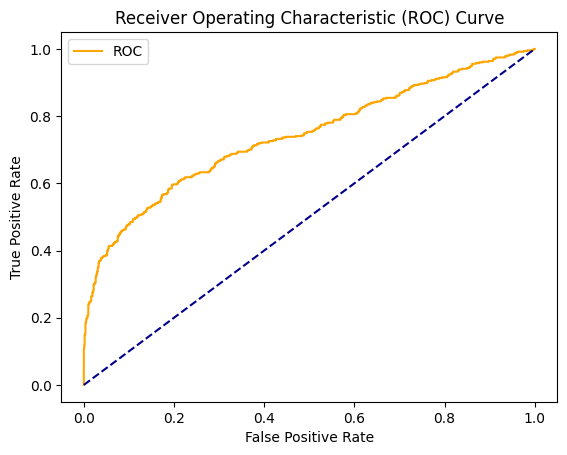


AUC-ROC score for Self-enhancement is: 0.7366066452268731
Threshold value for Self-enhancement is: 0.013267768


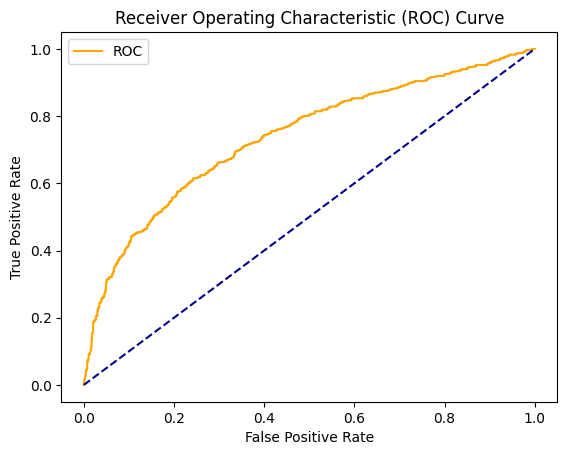


AUC-ROC score for Conservation is: 0.7397850534726419
Threshold value for Conservation is: 0.9996246


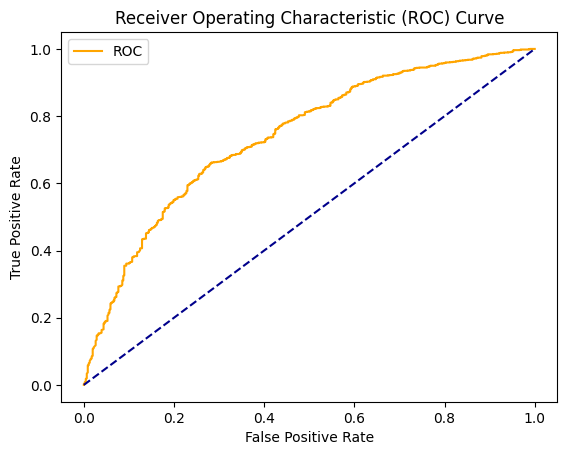


AUC-ROC score for Self-transcendence is: 0.6879724179605883
Threshold value for Self-transcendence is: 0.9995553


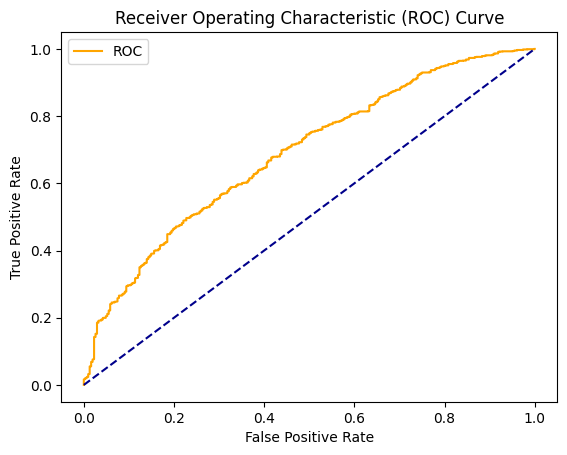

Seed 42: Test accuracy = [0.741751269035533, 0.6986040609137056, 0.6776649746192893, 0.550761421319797], Test f1 score = [0.6971164220911713, 0.6868766341622361, 0.6540203419831705, 0.5211354647330257]


Epoch,Training Loss,Validation Loss
1,0.498600,0.595718
2,0.496000,0.594673
3,0.495400,0.597082
4,0.495500,0.593069
5,0.491800,0.600838
6,0.492600,0.594027
7,0.489800,0.593272
8,0.491000,0.596781
9,0.489800,0.597094
10,0.489500,0.595715



AUC-ROC score for Openness to change is: 0.7368736933998024
Threshold value for Openness to change is: 0.0018424988


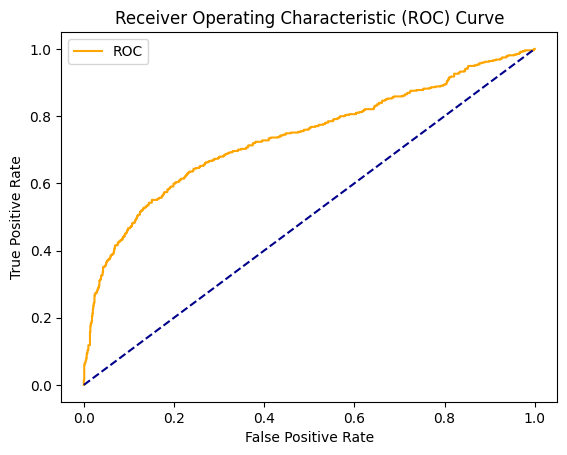


AUC-ROC score for Self-enhancement is: 0.7235739015710501
Threshold value for Self-enhancement is: 0.00061068893


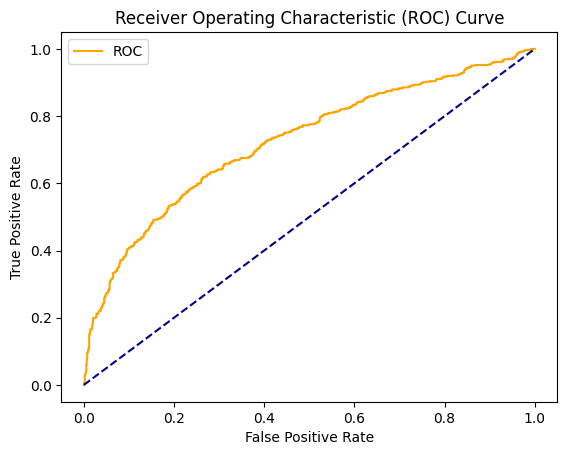


AUC-ROC score for Conservation is: 0.7310088524647866
Threshold value for Conservation is: 0.9986871


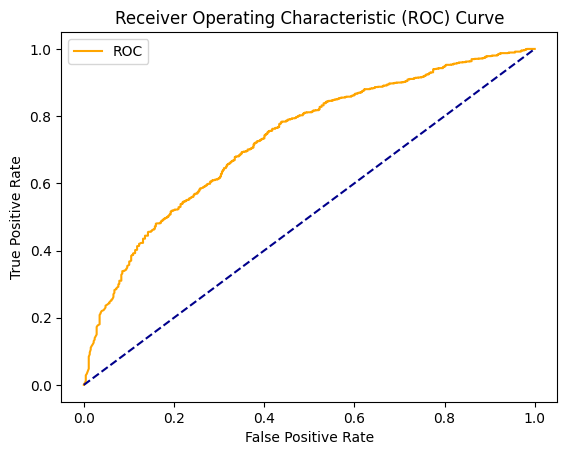


AUC-ROC score for Self-transcendence is: 0.6962698185095662
Threshold value for Self-transcendence is: 0.99992406


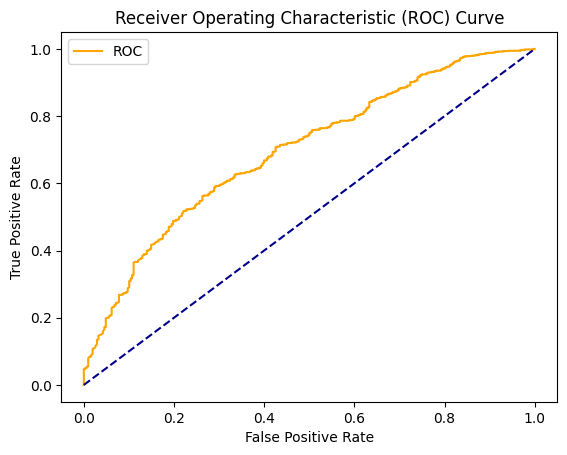

Seed 123: Test accuracy = [0.7271573604060914, 0.6878172588832487, 0.7189086294416244, 0.6148477157360406], Test f1 score = [0.689942626026006, 0.6773394587036852, 0.6676363826784061, 0.5651053990863245]


Epoch,Training Loss,Validation Loss
1,0.494800,0.596760
2,0.492500,0.600504
3,0.492400,0.594705
4,0.493300,0.596595
5,0.489300,0.594778
6,0.489500,0.592031
7,0.488400,0.598493
8,0.488900,0.594273
9,0.487900,0.599518
10,0.487900,0.595367



AUC-ROC score for Openness to change is: 0.7465061606438619
Threshold value for Openness to change is: 0.0026515936


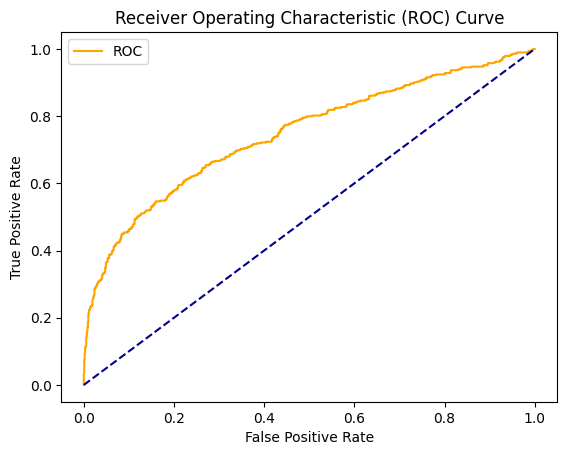


AUC-ROC score for Self-enhancement is: 0.7383785060800615
Threshold value for Self-enhancement is: 0.0012635515


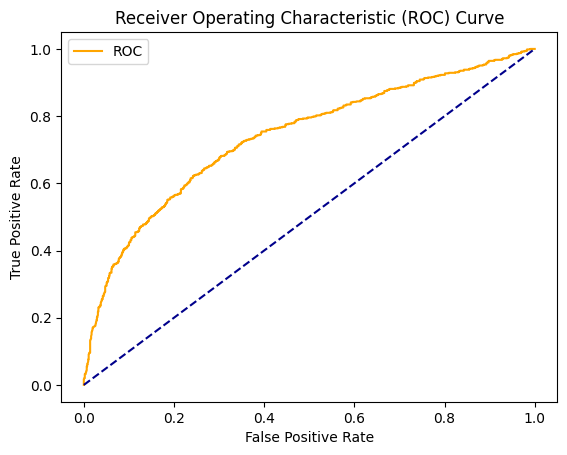


AUC-ROC score for Conservation is: 0.7265826200714532
Threshold value for Conservation is: 0.99998105


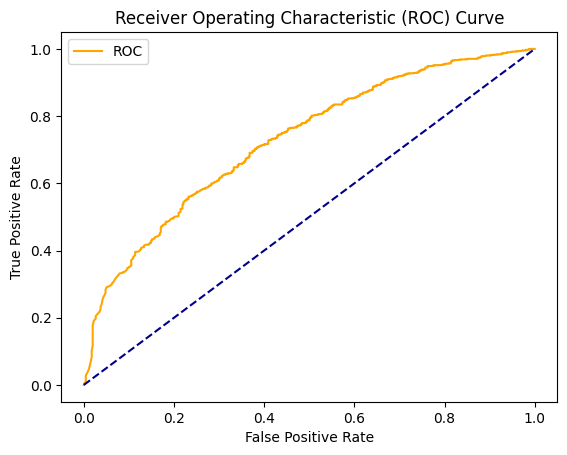


AUC-ROC score for Self-transcendence is: 0.6836617641034045
Threshold value for Self-transcendence is: 0.9999535


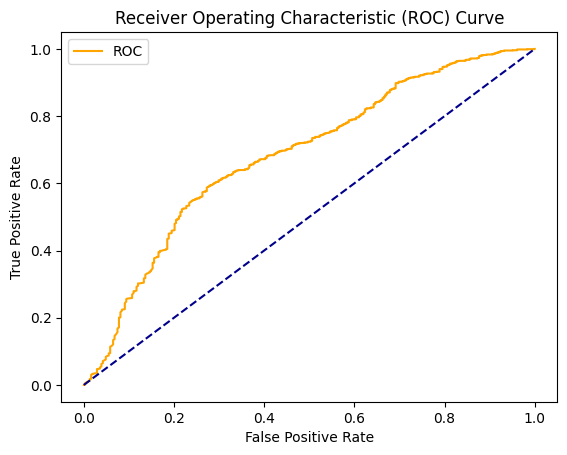

Seed 999: Test accuracy = [0.7519035532994924, 0.7017766497461929, 0.6205583756345178, 0.6148477157360406], Test f1 score = [0.6977684393495078, 0.690564196482879, 0.6085529157667386, 0.567591707404168]


In [ ]:
seeds = [42, 123, 999]
num_epochs = 20
models_2 = {}

for seed in seeds:
    np.random.seed(seed)
    torch.manual_seed(seed)

    trainer_cp = Trainer(
        model=bert_cp,
        args=cp_training_args,
        train_dataset=train_cp,
        eval_dataset=val_cp,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )

    trainer_cp.train()

    models_2[seed] = trainer_cp

    test_prediction_cp_info = trainer_cp.predict(test_cp)
    test_predictions_cp = test_prediction_cp_info.predictions
    test_labels_cp = test_prediction_cp_info.label_ids

    thresholds_list_cp = []
    for i in range(4):
      y_true = test_labels_cp[:,i]
      y_scores = test_predictions_cp[:,i]

      fpr, tpr, thresholds = roc_curve(y_true, y_scores)
      print()
      print(f"AUC-ROC score for {l3_classes[i]} is:", roc_auc_score(y_true, y_scores))

      optimal_idx = np.argmax(tpr - fpr)
      optimal_threshold = thresholds[optimal_idx]
      print(f"Threshold value for {l3_classes[i]} is:", optimal_threshold)

      thresholds_list_cp.append(optimal_threshold)
      plot_roc_curve(fpr, tpr)

    pred_cp, label_cp = transform_data(test_predictions_cp, test_labels_cp, thresholds_list_cp)
    f1_list_cp, acc_list_cp = compute_metrics(pred_cp, label_cp)
    print(f"Seed {seed}: Test accuracy = {acc_list_cp}, Test f1 score = {f1_list_cp}")

In [ ]:
f1_list_cp

[0.6977684393495078, 0.690564196482879, 0.6085529157667386, 0.567591707404168]

In [ ]:
acc_list_cp

[0.7519035532994924,
 0.7017766497461929,
 0.6205583756345178,
 0.6148477157360406]

In [ ]:
trainer_cp.save_model(output_dir = cp_path)
#!zip -r /content/best_checkpoints.zip /content/best_checkpoints

In [ ]:
!zip -r /content/best_checkpoints.zip /content/best_checkpoints

  adding: content/best_checkpoints/ (stored 0%)
  adding: content/best_checkpoints/bert_c/ (stored 0%)
  adding: content/best_checkpoints/bert_cps/ (stored 0%)
  adding: content/best_checkpoints/bert_cp/ (stored 0%)
  adding: content/best_checkpoints/bert_cp/model.safetensors (deflated 7%)
  adding: content/best_checkpoints/bert_cp/special_tokens_map.json (deflated 42%)
  adding: content/best_checkpoints/bert_cp/config.json (deflated 52%)
  adding: content/best_checkpoints/bert_cp/tokenizer.json (deflated 71%)
  adding: content/best_checkpoints/bert_cp/tokenizer_config.json (deflated 76%)
  adding: content/best_checkpoints/bert_cp/training_args.bin (deflated 50%)
  adding: content/best_checkpoints/bert_cp/vocab.txt (deflated 53%)


#### Bert with CPS

In [ ]:
cps_training_args = TrainingArguments(
    output_dir="cps_test_dir",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit = 2,
    load_best_model_at_end=True,
    report_to='none',
    weight_decay=0.01,
)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,0.619000,0.600412
2,0.595400,0.592385
3,0.570200,0.590532
4,0.556100,0.597395
5,0.546400,0.589117
6,0.532200,0.587410
7,0.523500,0.587872
8,0.517800,0.590862
9,0.509900,0.594875
10,0.505800,0.592797



AUC-ROC score for Openness to change is: 0.7481315138566625
Threshold value for Openness to change is: 0.056669258


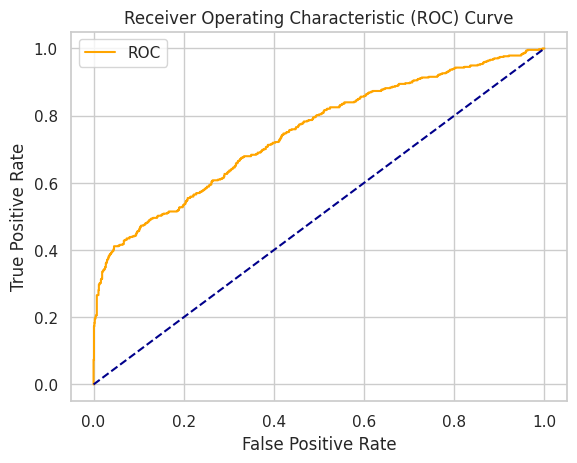


AUC-ROC score for Self-enhancement is: 0.7303676985607166
Threshold value for Self-enhancement is: 0.0028368318


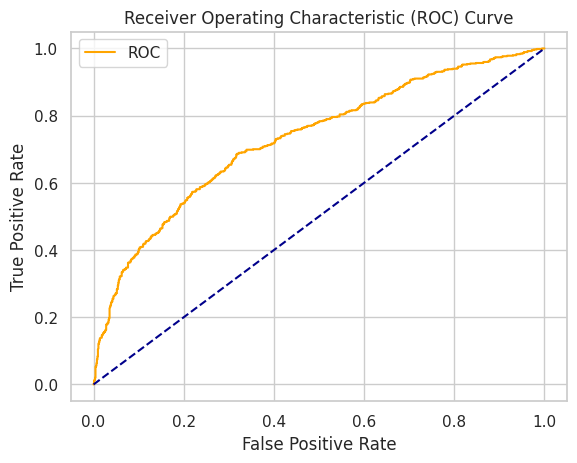


AUC-ROC score for Conservation is: 0.7279905667572055
Threshold value for Conservation is: 0.9987835


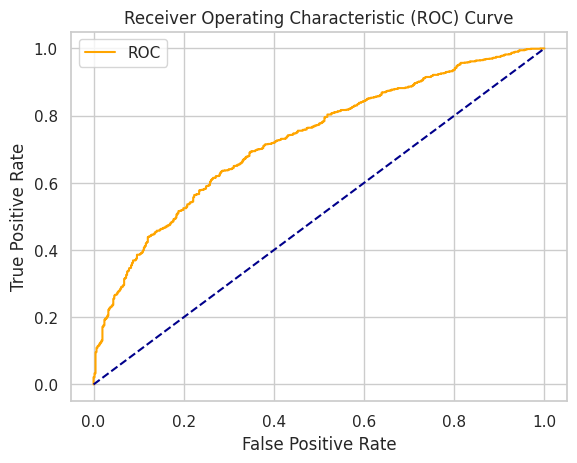


AUC-ROC score for Self-transcendence is: 0.6866076549633333
Threshold value for Self-transcendence is: 0.9924004


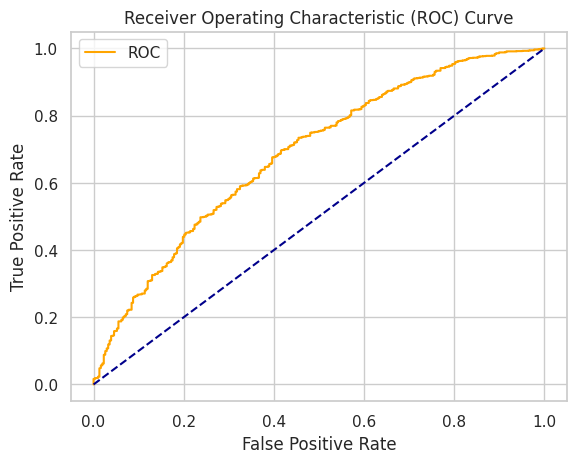

Seed 42: Test accuracy = [0.7677664974619289, 0.684010152284264, 0.6586294416243654, 0.674492385786802], Test f1 score = [0.6969122478104515, 0.679349717854814, 0.6370839611012191, 0.5936362032542759]


Epoch,Training Loss,Validation Loss
1,0.524300,0.592133
2,0.516200,0.594468
3,0.511000,0.590714
4,0.507800,0.594207
5,0.503400,0.588362
6,0.501300,0.599315
7,0.498100,0.592521
8,0.497100,0.594796
9,0.495500,0.594477
10,0.494500,0.594851



AUC-ROC score for Openness to change is: 0.748836025025462
Threshold value for Openness to change is: 0.0019416192


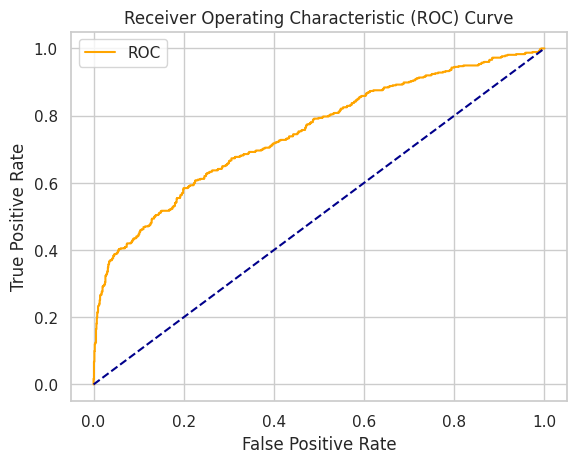


AUC-ROC score for Self-enhancement is: 0.742414688643287
Threshold value for Self-enhancement is: 0.002933915


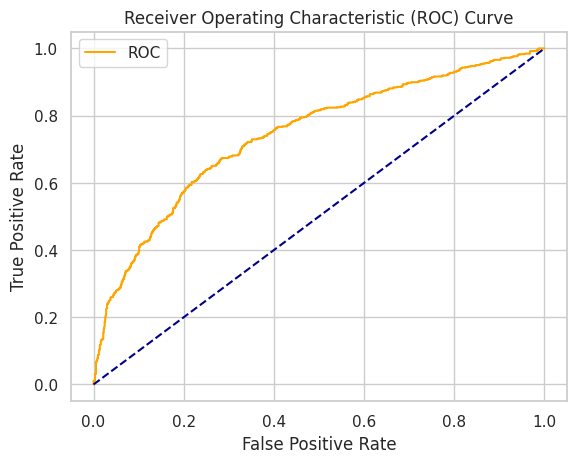


AUC-ROC score for Conservation is: 0.7326915443024113
Threshold value for Conservation is: 0.9995146


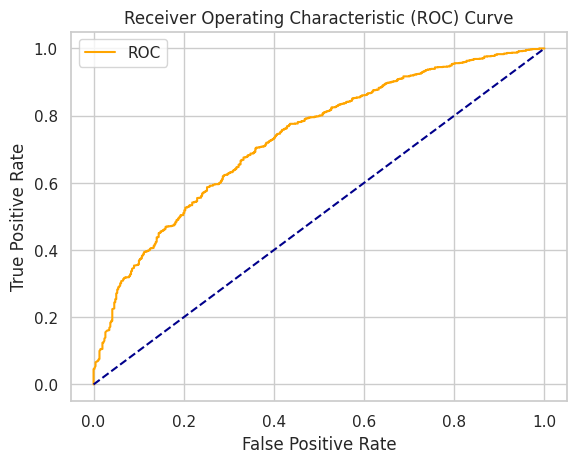


AUC-ROC score for Self-transcendence is: 0.671917888893441
Threshold value for Self-transcendence is: 0.99965775


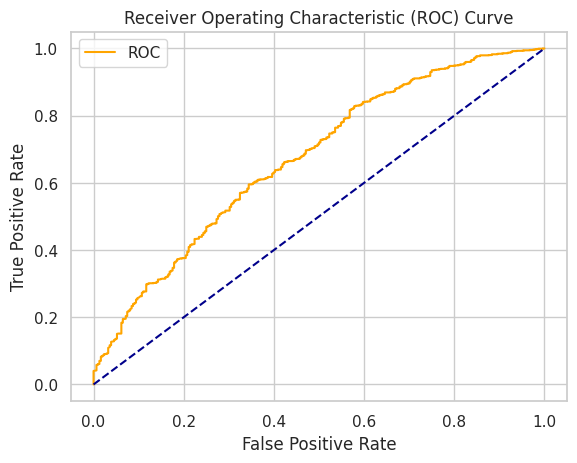

Seed 123: Test accuracy = [0.7354060913705583, 0.6986040609137056, 0.6859137055837563, 0.6072335025380711], Test f1 score = [0.6896745651400944, 0.692103309498691, 0.6512287600809561, 0.5520850407742633]


Epoch,Training Loss,Validation Loss
1,0.502600,0.595818
2,0.498700,0.595959
3,0.497300,0.596463
4,0.496900,0.592838
5,0.493600,0.594758
6,0.494600,0.594383
7,0.493200,0.593699
8,0.492500,0.596697
9,0.491700,0.599075


Epoch,Training Loss,Validation Loss
1,0.502600,0.595818
2,0.498700,0.595959
3,0.497300,0.596463
4,0.496900,0.592838
5,0.493600,0.594758
6,0.494600,0.594383
7,0.493200,0.593699
8,0.492500,0.596697
9,0.491700,0.599075
10,0.491300,0.596916



AUC-ROC score for Openness to change is: 0.754229938661582
Threshold value for Openness to change is: 4.771285e-05


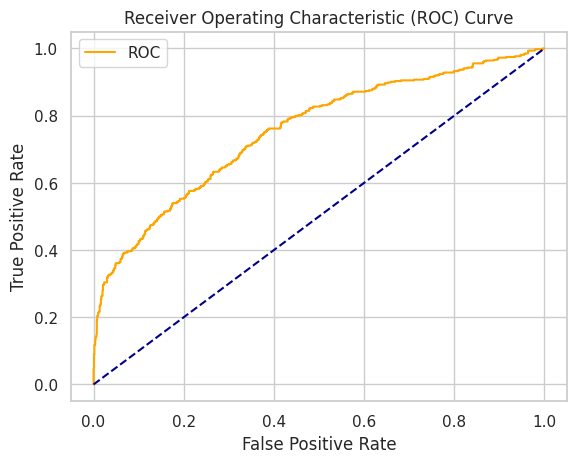


AUC-ROC score for Self-enhancement is: 0.7444020011213467
Threshold value for Self-enhancement is: 0.060917255


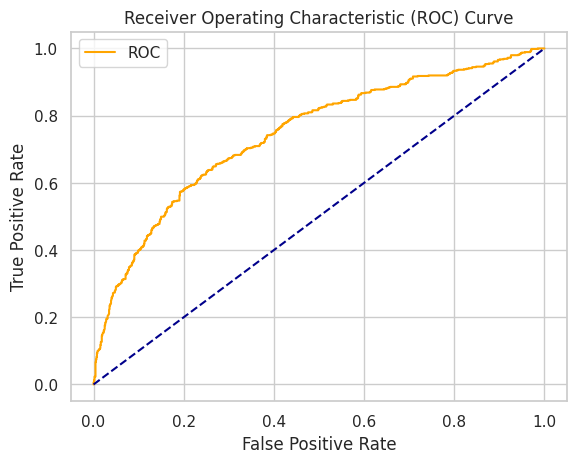


AUC-ROC score for Conservation is: 0.723382474583629
Threshold value for Conservation is: 0.999711


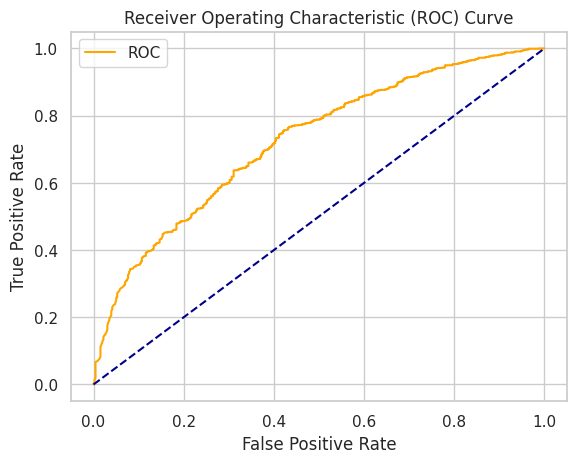


AUC-ROC score for Self-transcendence is: 0.6598245012085706
Threshold value for Self-transcendence is: 0.99991405


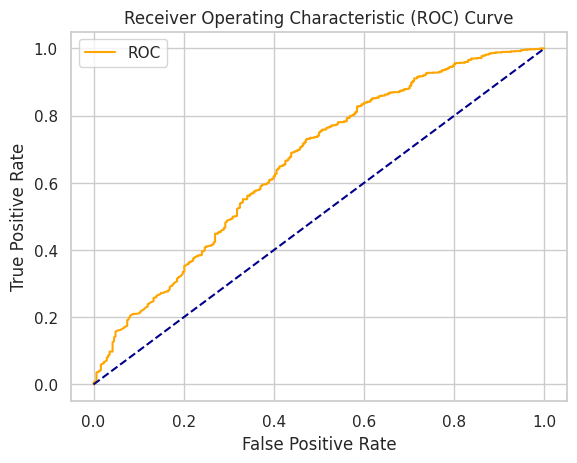

Seed 999: Test accuracy = [0.6567258883248731, 0.6986040609137056, 0.7049492385786802, 0.6897208121827412], Test f1 score = [0.6426299361180514, 0.6906313707063532, 0.6581722824010781, 0.5953786906290115]


In [ ]:
seeds = [42, 123, 999]
num_epochs = 20
models_3 = {}

for seed in seeds:
    np.random.seed(seed)
    torch.manual_seed(seed)

    trainer_cps = Trainer(
        model=bert_cps,
        args=cps_training_args,
        train_dataset=train_cps,
        eval_dataset=val_cps,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )

    trainer_cps.train()

    models_3[seed] = trainer_cps

    test_prediction_cps_info = trainer_cps.predict(test_cps)
    test_predictions_cps = test_prediction_cps_info.predictions
    test_labels_cps = test_prediction_cps_info.label_ids

    thresholds_list_cps = []
    for i in range(4):
      y_true = test_labels_cps[:,i]
      y_scores = test_predictions_cps[:,i]

      fpr, tpr, thresholds = roc_curve(y_true, y_scores)
      print()
      print(f"AUC-ROC score for {l3_classes[i]} is:", roc_auc_score(y_true, y_scores))

      optimal_idx = np.argmax(tpr - fpr)
      optimal_threshold = thresholds[optimal_idx]
      print(f"Threshold value for {l3_classes[i]} is:", optimal_threshold)

      thresholds_list_cps.append(optimal_threshold)
      plot_roc_curve(fpr, tpr)

    pred_cps, label_cps = transform_data(test_predictions_cps, test_labels_cps, thresholds_list_cps)
    f1_list_cps, acc_list_cps = compute_metrics(pred_cps, label_cps)
    print(f"Seed {seed}: Test accuracy = {acc_list_cps}, Test f1 score = {f1_list_cps}")

In [ ]:
f1_list_cps

[0.6426299361180514,
 0.6906313707063532,
 0.6581722824010781,
 0.5953786906290115]

In [ ]:
acc_list_cps

[0.6567258883248731,
 0.6986040609137056,
 0.7049492385786802,
 0.6897208121827412]

In [ ]:
trainer_cps.save_model(output_dir = cps_path)
#now we zip the folder so we can download it
!zip -r /content/best_checkpoints.zip /content/best_checkpoints

  adding: content/best_checkpoints/ (stored 0%)
  adding: content/best_checkpoints/bert_c/ (stored 0%)
  adding: content/best_checkpoints/bert_cps/ (stored 0%)
  adding: content/best_checkpoints/bert_cps/model.safetensors (deflated 7%)
  adding: content/best_checkpoints/bert_cps/special_tokens_map.json (deflated 42%)
  adding: content/best_checkpoints/bert_cps/config.json (deflated 52%)
  adding: content/best_checkpoints/bert_cps/tokenizer.json (deflated 71%)
  adding: content/best_checkpoints/bert_cps/tokenizer_config.json (deflated 76%)
  adding: content/best_checkpoints/bert_cps/training_args.bin (deflated 50%)
  adding: content/best_checkpoints/bert_cps/vocab.txt (deflated 53%)
  adding: content/best_checkpoints/bert_cp/ (stored 0%)


## [Task 5 - 1.0 points] Error Analysis

You are tasked to discuss your results.

### Instructions

* **Compare** classification performance of BERT-based models with respect to baselines.
* Discuss **difference in prediction** between the best performing BERT-based model and its variants.

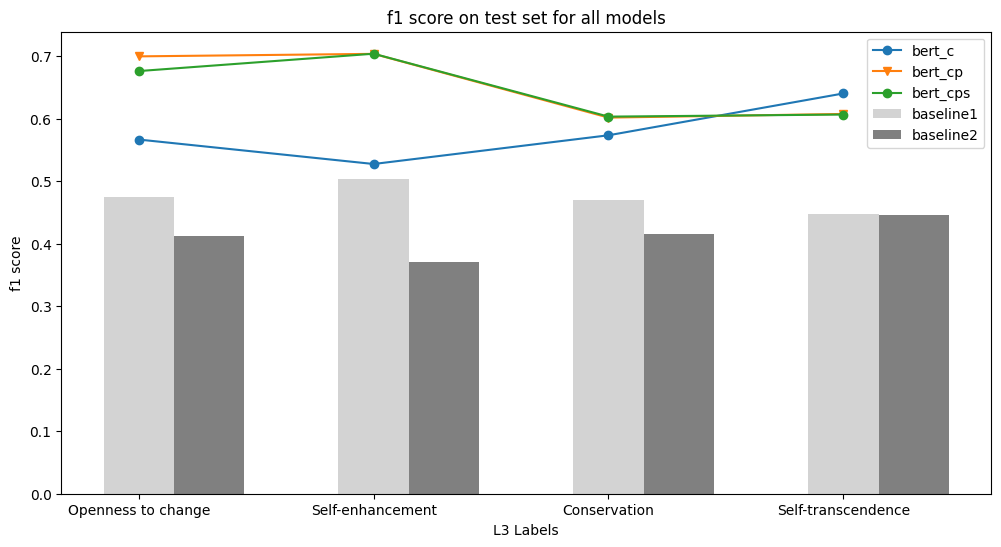

In [ ]:
plt.figure(figsize=(12,6))

X_axis = np.arange(4)

# Plot the bar chart
plt.plot(X_axis, f1_list_c, '-o', label = 'bert_c')
plt.plot(X_axis, f1_list_cp, '-v', label = 'bert_cp')
plt.plot(X_axis, f1_list_cps, '-o', label = 'bert_cps')
plt.bar(X_axis, f1_base1_list, 0.3, label='baseline1', color = 'lightgrey')
plt.bar(X_axis + 0.3,f1_base2_list, 0.3, label='baseline2', color = 'grey')

plt.xticks(X_axis, l3_classes)
plt.xlabel("L3 Labels")
plt.ylabel("f1 score")
plt.title("f1 score on test set for all models")
plt.legend()
plt.show()

In [ ]:
table = [['Models','F1_Avg', 'Accuracy_Avg'],
         ['Baseline_1',sum(f1_base1_list)/len(f1_base1_list),sum(acc_base1_list)/len(acc_base1_list)],
         ['Baseline_2',sum(f1_base2_list)/len(f1_base2_list),sum(acc_base2_list)/len(acc_base2_list)],
         ['Bert_c',sum(f1_list_c)/len(f1_list_c),sum(acc_list_c)/len(acc_list_c)],
         ['Bert_cp',sum(f1_list_cp)/len(f1_list_cp),sum(acc_list_cp)/len(acc_list_cp)],
         ['Bert_cps',sum(f1_list_cps)/len(f1_list_cps),sum(acc_list_cps)/len(acc_list_cps)]]


print(tabulate(table, headers='firstrow'))

Models        F1_Mean    Accuracy_Mean
----------  ---------  ---------------
Baseline_1   0.473435         0.498255
Baseline_2   0.410856         0.700825
Bert_c       0.576717         0.647049
Bert_cp      0.652888         0.703522
Bert_cps     0.647212         0.686707


**CONFUSION MATRIX OF BERT_C**

Confusion Matrix for Openness to change


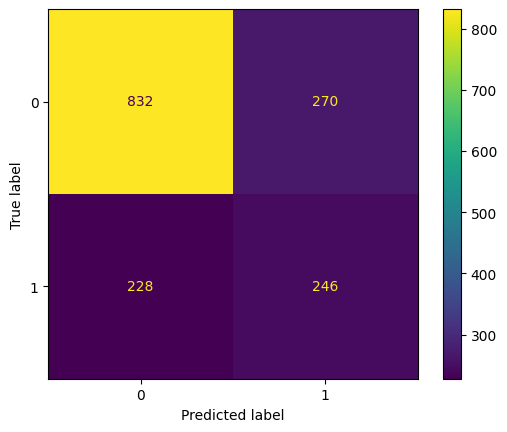

Confusion Matrix for Self-enhancement


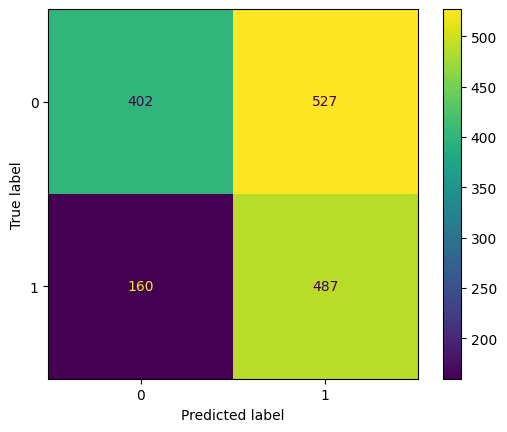

Confusion Matrix for Conservation


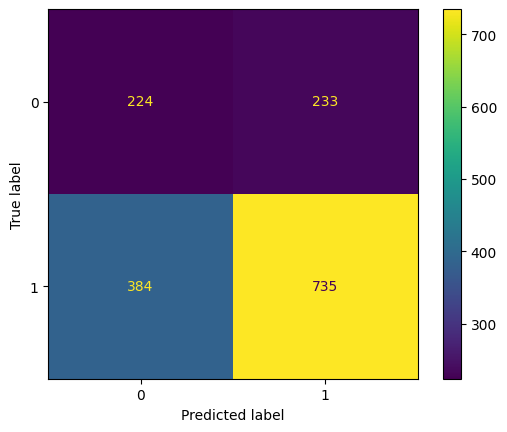

Confusion Matrix for Self-transcendence


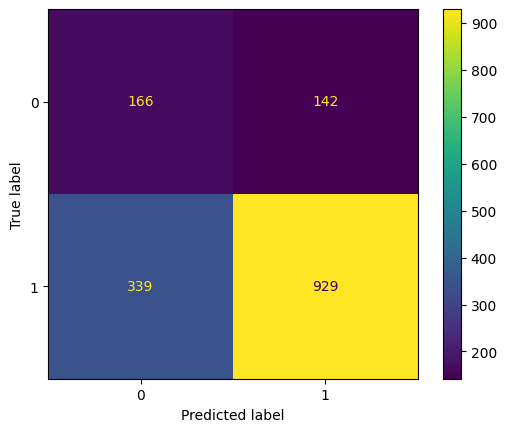

In [ ]:
for i in range(4):
  conf_matrix_c = confusion_matrix(label_c[:,i], pred_c[:,i])
  disp = ConfusionMatrixDisplay(conf_matrix_c)
  print("Confusion Matrix for", l3_classes[i])
  disp.plot()
  plt.show()

**CONFUSION MATRIX OF BERT_CP**

Confusion Matrix for Openness to change


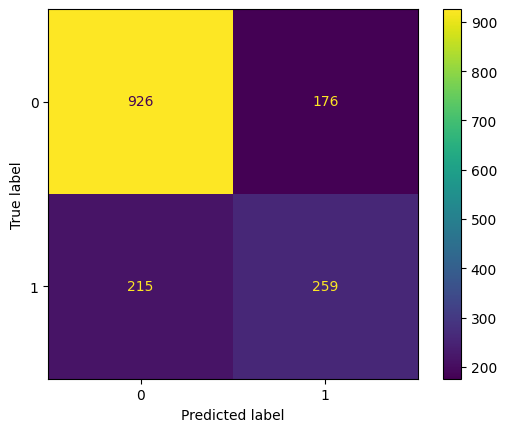

Confusion Matrix for Self-enhancement


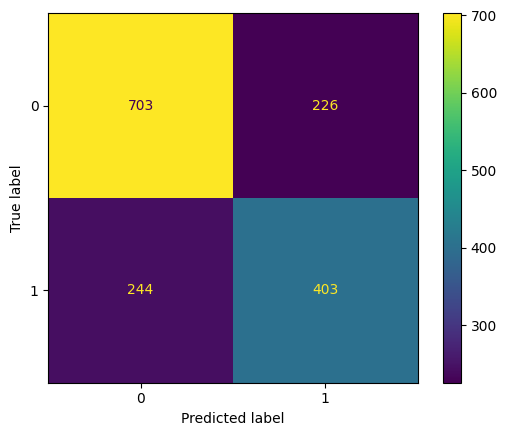

Confusion Matrix for Conservation


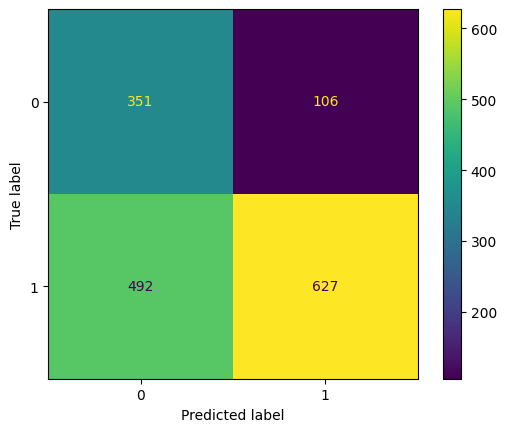

Confusion Matrix for Self-transcendence


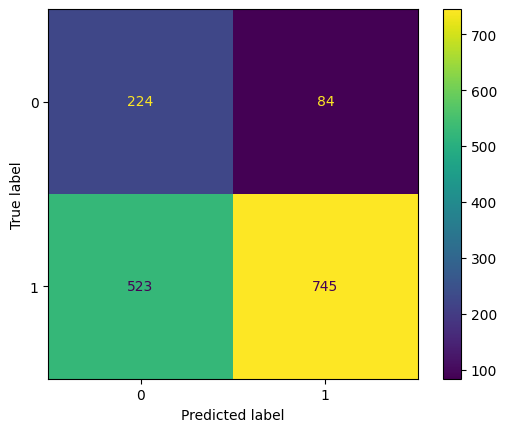

In [ ]:
for i in range(4):
  conf_matrix_cp = confusion_matrix(label_cp[:,i], pred_cp[:,i])
  disp = ConfusionMatrixDisplay(conf_matrix_cp)
  print("Confusion Matrix for", l3_classes[i])
  disp.plot()
  plt.show()

**CONFUSION MATRIX OF BERT_CPS**

Confusion Matrix for Openness to change


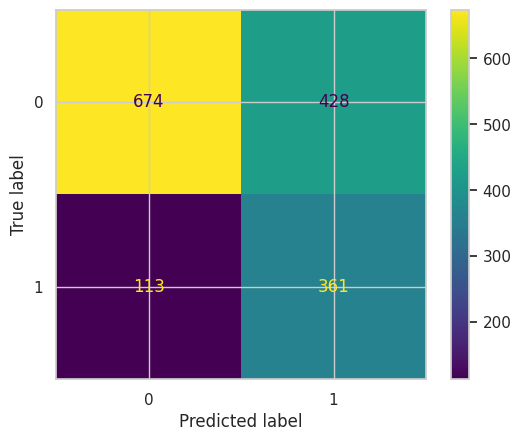

Confusion Matrix for Self-enhancement


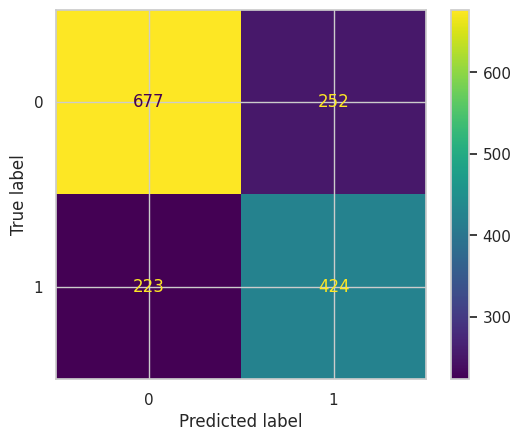

Confusion Matrix for Conservation


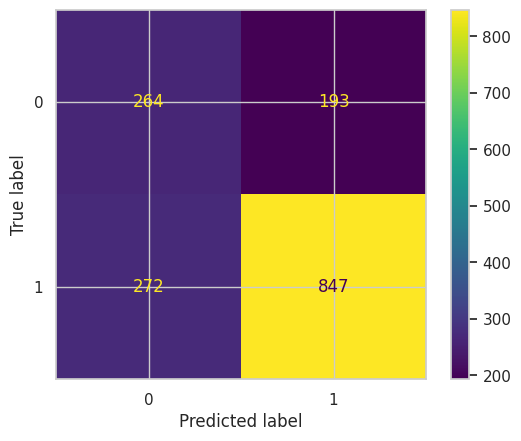

Confusion Matrix for Self-transcendence


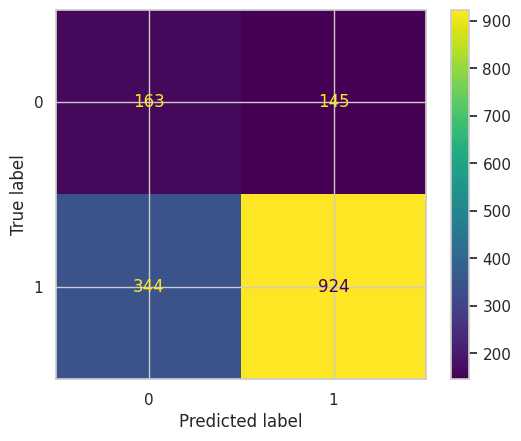

In [ ]:
for i in range(4):
  conf_matrix_cps = confusion_matrix(label_cps[:,i], pred_cps[:,i])
  disp = ConfusionMatrixDisplay(conf_matrix_cps)
  print("Confusion Matrix for", l3_classes[i])
  disp.plot()
  plt.show()

Let's check the percentage of majority classes among the duplicated conclusions

In [ ]:
def majority_duplicated(x, y):
  duplicate_index = {tuple(v) for k,v in x.groupby('Conclusion').groups.items() if len(v) > 1}
  y2 = np.array(y.values.tolist())
  majority_class_percentage = np.zeros(4)
  for i in duplicate_index:
    index = list(i)
    for i in range(4):
        majority_class_percentage[i] += mode(y2[index][:,i])[1]/len(index)
  return majority_class_percentage/len(duplicate_index)

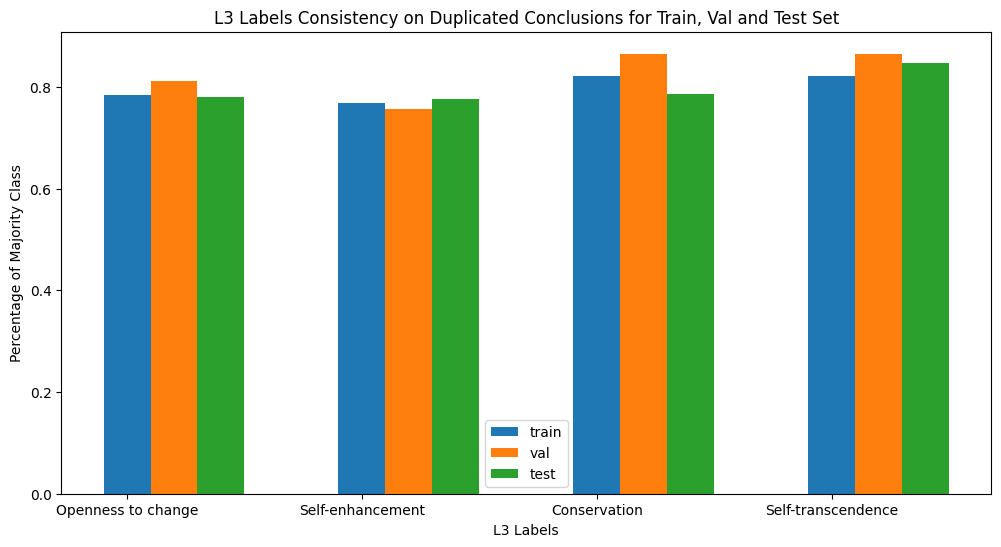

In [ ]:
plt.figure(figsize=(12,6))

X_axis = np.arange(4)

# Plot the bar chart
plt.bar(X_axis, majority_duplicated(X_train, y_train), 0.2, label='train')
plt.bar(X_axis + 0.2,majority_duplicated(X_val, y_val), 0.2, label='val')
plt.bar(X_axis + 0.4,majority_duplicated(X_test, y_test), 0.2, label='test')

plt.xticks(X_axis, l3_classes)
plt.xlabel("L3 Labels")
plt.ylabel("Percentage of Majority Class")
plt.title("L3 Labels Consistency on Duplicated Conclusions for Train, Val and Test Set")
plt.legend()
plt.show()

In [ ]:
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')

In [ ]:
allWords = nltk.tokenize.word_tokenize(str(train_df['Conclusion'] + train_df['Premise']))
stopwords = set(nltk.corpus.stopwords.words('english') + list(string.punctuation))
allWordExceptStopDist = nltk.FreqDist(w.lower() for w in allWords if w not in stopwords)


In [ ]:
allWordExceptStopDist.most_common(20)

[('...', 11),
 ('we', 5),
 ('ban', 5),
 ('food', 4),
 ('whose', 3),
 ('production', 3),
 ('subsidized', 3),
 ('human', 2),
 ('the', 2),
 ('eu', 2),
 ('integrate', 2),
 ('armed', 2),
 ('forces', 2),
 ('0', 1),
 ('cloningwe', 1),
 ('1', 1),
 ('fast', 1),
 ('foodfast', 1),
 ('2', 1),
 ('end', 1)]

In [ ]:
words_set = ['food', 'ban','production', 'subsidized','eu', 'human','integrate', 'armed', 'forces']
n_docs = 4         #·Number of classes
n_words_set = len(words_set) #·Number of most frequent words in the dataset

df_tf = pd.DataFrame(np.zeros((n_docs, n_words_set)), columns=words_set)

l1_tokens = nltk.tokenize.word_tokenize(str(train_df[train_df['Openness to change']==1]['Conclusion']+train_df[train_df['Openness to change']==1]['Premise'] ))
l2_tokens = nltk.tokenize.word_tokenize(str(train_df[train_df['Self-enhancement']==1]['Conclusion'] + train_df[train_df['Self-enhancement']==1]['Premise']))
l3_tokens = nltk.tokenize.word_tokenize(str(train_df[train_df['Conservation']==1]['Conclusion'] + train_df[train_df['Conservation']==1]['Premise']))
l4_tokens = nltk.tokenize.word_tokenize(str(train_df[train_df['Self-transcendence']==1]['Conclusion'] + train_df[train_df['Self-transcendence']==1]['Premise']))

tokens_list = [l1_tokens, l2_tokens, l3_tokens, l4_tokens]
for i in range(n_docs):
  for w in words_set:
        df_tf[w][i] = tokens_list[i].count(w) / len(tokens_list[i])


In [ ]:
df_tf.style.background_gradient()

,food,ban,production,subsidized,eu,human,integrate,armed,forces
0,0.000000,0.018018,0.000000,0.000000,0.000000,0.000000,0.018018,0.018018,0.018018
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046296,0.046296,0.046296
2,0.009346,0.046729,0.018692,0.018692,0.000000,0.018692,0.028037,0.028037,0.028037
3,0.000000,0.009709,0.029126,0.029126,0.000000,0.000000,0.019417,0.019417,0.019417


In [ ]:
allWords = nltk.tokenize.word_tokenize(str(test_df['Conclusion'] + test_df['Premise']))
stopwords = set(nltk.corpus.stopwords.words('english') + list(string.punctuation))
allWordExceptStopDist = nltk.FreqDist(w.lower() for w in allWords if w not in stopwords)


In [ ]:
allWordExceptStopDist.most_common(20)

[('...', 11),
 ('we', 10),
 ('end', 4),
 ('affirmative', 2),
 ('actionaffirmative', 2),
 ('ac', 2),
 ('ban', 2),
 ('mass', 2),
 ('migration', 2),
 ('together.mass', 2),
 ('mig', 2),
 ('0', 1),
 ('1', 1),
 ('2', 1),
 ('naturopathynaturopathy', 1),
 ('3', 1),
 ('prohibit', 1),
 ('women', 1),
 ('combatwomen', 1),
 ('4', 1)]

In [ ]:
words_set = ['end', 'affirmative','ban', 'mass','migration']
n_docs = 4         #·Number of classes
n_words_set = len(words_set) #·Number of most frequent words in the dataset

df_tf = pd.DataFrame(np.zeros((n_docs, n_words_set)), columns=words_set)

l1_tokens = nltk.tokenize.word_tokenize(str(test_df[test_df['Openness to change']==1]['Conclusion']+test_df[test_df['Openness to change']==1]['Premise'] ))
l2_tokens = nltk.tokenize.word_tokenize(str(test_df[test_df['Self-enhancement']==1]['Conclusion'] + test_df[test_df['Self-enhancement']==1]['Premise']))
l3_tokens = nltk.tokenize.word_tokenize(str(test_df[test_df['Conservation']==1]['Conclusion'] + test_df[test_df['Conservation']==1]['Premise']))
l4_tokens = nltk.tokenize.word_tokenize(str(test_df[test_df['Self-transcendence']==1]['Conclusion'] + test_df[test_df['Self-transcendence']==1]['Premise']))

tokens_list = [l1_tokens, l2_tokens, l3_tokens, l4_tokens]
for i in range(n_docs):
  for w in words_set:
        df_tf[w][i] = tokens_list[i].count(w) / len(tokens_list[i])


In [ ]:
df_tf.style.background_gradient()

,end,affirmative,ban,mass,migration
0,0.010417,0.000000,0.000000,0.000000,0.010417
1,0.031579,0.021053,0.021053,0.000000,0.021053
2,0.042105,0.010526,0.021053,0.021053,0.021053
3,0.052083,0.020833,0.020833,0.010417,0.010417
